# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
import os
# filename = os.path.join(os.getcwd(), 'p3_collab-compet', 'Tennis.app')
filename = 'Tennis.app'
env = UnityEnvironment(file_name=filename)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from sumtree import SumTree

%matplotlib inline

# Hyperparameters

In [6]:
BUFFER_SIZE = int(1e7)            # replay buffer size
BATCH_SIZE = 256                  # minbatch size
GAMMA = 0.99                      # discount factor
TAU = 5e-2                        # for soft update of target parameters
LR_ACTOR = 1e-4                   # learning rate of the actor
LR_CRITIC = 5e-3                  # learning rate of the critic
WEIGHT_DECAY = 0                  # L2 weight decay
UPDATE_EVERY = 10                 # number of timesteps before updating the network
UPDATE_NETWORK = 20               # how many times to update the network
EPSILON = 1                       # epsilon
EPSILON_DECAY = 0.999             # rate at which we should decay epsilon
EPSILON_MIN = 0.1                 # minimum epsilon
MAX_CLIPPING_NORMALIZATION = 1.0  # gradient clipping normalization max value

PRIORITY_A = 0.4                  # alpha for PER
PRIORITY_B = 1 - PRIORITY_A       # beta for PER
PRIORITY_E = 0.01                 # e for PER

CUTOFF_SCORE = 0.5                # average score over the window to consider environment as solved
CUTOFF_WINDOW = 100               # window size

NOISE_MU = 0.
NOISE_THETA = 0.4
NOISE_SIGMA = 0.8

# Action-Critic Network Models

In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.bn1(self.fc1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


# DDPG Agent

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.t_step = 0

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = PrioritizedReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
        # Epsilon
        self.epsilon = EPSILON

    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)

        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # Learn, if enough samples are available in memory
            if len(self.memory) > BATCH_SIZE:
                for i in range(UPDATE_NETWORK):
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.epsilon * self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones, indices, probabilities = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Compute absolute TD error delta for prioritized replay buffer and update the weights
        absolute_td_delta = torch.abs(Q_targets - Q_expected)
        if probabilities:
            weights = np.array(probabilities).reshape(-1, 1) * len(self.memory) ** (-PRIORITY_B)
            weights /= np.max(weights)
        else:
            weights = np.ones(critic_loss.shape, dtype=np.float)
            
        if indices:
            self.memory.update(indices, list(absolute_td_delta.detach().to('cpu').numpy().squeeze() ** PRIORITY_A + PRIORITY_E))

        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), MAX_CLIPPING_NORMALIZATION)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), MAX_CLIPPING_NORMALIZATION)
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

        # ----------------------- update noise --------------------------------- #
        self.noise.reset()
        self.epsilon = max(EPSILON_MIN, self.epsilon * EPSILON_DECAY)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=NOISE_MU, theta=NOISE_THETA, sigma=NOISE_SIGMA):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state


class PrioritizedReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.memory = SumTree(buffer_size)
        self.internal_buffer = []
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.internal_buffer.append(e)

    def sample(self):
        buffer_size = len(self.internal_buffer)
        memory_size = self.batch_size - buffer_size

        experiences = []
        indices = []
        probabilities = []
        if memory_size:
            for i in range(memory_size):
                s = random.uniform(0, self.memory.total())
                idx, probability, e = self.memory.get(s)
                experiences.append(e)
                indices.append(idx)
                probabilities.append(probability / self.memory.total())
        for e in self.internal_buffer:
            experiences.append(e)
            idx = self.memory.add(0.0, e)
            indices.append(idx)
            probabilities.append(1 / len(self))

        self.internal_buffer.clear()

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones, indices, probabilities)

    def update(self, indices, priority_values):
        for idx, priority in zip(indices, priority_values):
            self.memory.update(idx, priority)

    def __len__(self):
        return max(len(self.memory), len(self.internal_buffer)

In [9]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)

In [10]:
def ddpg(n_episodes=5000, max_t=1000, print_every=CUTOFF_WINDOW):
    scores_deque = deque(maxlen=print_every)
    scores_list = []
    averages_list = []
    try:
        for i_episode in range(1, n_episodes + 1):
            env_info = env.reset(train_mode=True)[brain_name]
            states = env_info.vector_observations
            agent.reset()
            scores = np.zeros(num_agents)

            for _ in range(max_t):
                actions = agent.act(states)
                env_info = env.step(actions)[brain_name]
                next_states = env_info.vector_observations
                rewards = env_info.rewards
                dones = env_info.local_done
                agent.step(states, actions, rewards, next_states, dones)
                states = next_states
                scores += rewards
                if np.any(dones):
                    break

            scores_deque.append(np.max(scores))
            scores_list.append(np.max(scores))
            averages_list.append(np.mean(scores_deque))
            print('\rEpisode {}\tScore: {:.4f}\tAverage Score: {:.4f}'.format(i_episode, np.max(scores), np.mean(scores_deque)), end="")
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

            if i_episode % print_every == 0:
                print('\rEpisode {}\tScore: {:.4f}\tAverage Score: {:.4f}'.format(i_episode, np.max(scores), np.mean(scores_deque)))
            if np.mean(scores_deque) >= CUTOFF_SCORE:
                print('\nEnvironment solved in {} episodes'.format(i_episode))
                break
    except:
        import traceback
        traceback.print_exc()
    finally:
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        return averages_list, scores_list

averages_list, scores_list = ddpg()

Episode 100	Score: 0.7000	Average Score: 0.3912
Episode 113	Score: 2.6000	Average Score: 0.5182
Environment solved in 113 episodes


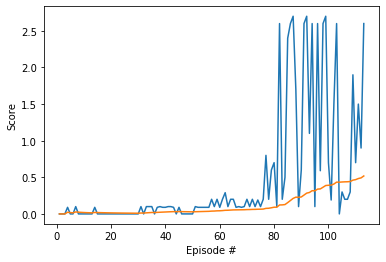

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_list) + 1), scores_list)
plt.plot(np.arange(1, len(averages_list) + 1), averages_list)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
fig.savefig('rewards.png')

# Check the agent in action

In [15]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location={'cuda:0': 'cpu'}))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth', map_location={'cuda:0': 'cpu'}))

max_t = 10000
for i in range(5):
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(num_agents)
    for _ in range(max_t):
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.max(scores)))

In [16]:
env.close()